In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time 
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from sklearn.preprocessing import StandardScaler
import math
import joblib

In [31]:
DATA_DIR = '/Users/macbookpro/Desktop/POC1/data/processed'

In [32]:
student_df = pd.read_csv(os.path.join(DATA_DIR , 'synthetic_student_data_combined.csv') )
student_df.head()

,school_pseudocode,state,district,rural_urban,grade,age,gender,caste,father_education,family_income,attendance_rate,grade_performance,midday_meal_access,free_text_books_access,free_uniform_access,internet_access_home,distance_to_school,dropout
0,9159944,ANDHRA PRADESH,KRISHNA,Rural,1,6,Male,OBC,Primary,< ₹2 Lakhs,58.4,59.2,1,1,1,0,2.1,0
1,9159944,ANDHRA PRADESH,KRISHNA,Rural,6,11,Male,SC,HigherSecondary,< ₹2 Lakhs,70.1,58.9,1,1,1,0,10.4,0
2,9159944,ANDHRA PRADESH,KRISHNA,Rural,7,12,Male,OBC,Graduate,₹2 - ₹3.5 Lakhs,71.7,58.1,1,1,1,0,2.7,0
3,9159944,ANDHRA PRADESH,KRISHNA,Rural,4,9,Female,OBC,NaN,< ₹2 Lakhs,100.0,73.3,1,1,1,0,2.2,0
4,9159944,ANDHRA PRADESH,KRISHNA,Rural,1,6,Female,OBC,Secondary,< ₹2 Lakhs,87.4,54.7,1,1,1,0,9.4,0


In [33]:
student_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   school_pseudocode       int64  
 1   state                   object 
 2   district                object 
 3   rural_urban             object 
 4   grade                   int64  
 5   age                     int64  
 6   gender                  object 
 7   caste                   object 
 8   father_education        object 
 9   family_income           object 
 10  attendance_rate         float64
 11  grade_performance       float64
 12  midday_meal_access      int64  
 13  free_text_books_access  int64  
 14  free_uniform_access     int64  
 15  internet_access_home    int64  
 16  distance_to_school      float64
 17  dropout                 int64  
dtypes: float64(3), int64(8), object(7)
memory usage: 412.0+ MB


In [34]:
school_data = pd.read_csv(os.path.join(DATA_DIR, 'comprehensive_school_data.csv'))
school_data.head()

,pseudocode,state,district,block,rural_urban,school_category,school_type,lowclass,highclass,special_school_for_cwsn,...,grade_9_total,grade_10_total,grade_11_total,grade_12_total,student_teacher_ratio,girl_ratio,female_teacher_ratio,infrastructure_score,free_text_books,free_uniforms
0,9511206,UTTAR PRADESH,KHERI,LAKHIMPUR,1,1,3,1,5,2,...,0.0,0.0,0.0,0.0,52.500000,0.542857,1.00,1.333333,1,1
1,8855749,BIHAR,KISHANGANJ,POTHIA,1,2,3,1,8,2,...,0.0,0.0,0.0,0.0,111.000000,0.479730,0.25,1.333333,0,0
2,5882762,MADHYA PRADESH,BARWANI,PATI,1,1,3,1,5,2,...,0.0,0.0,0.0,0.0,20.000000,0.475000,1.00,1.333333,0,0
3,4530584,WEST BENGAL,PURBA MEDINIPUR,TAMLUK,1,1,3,1,5,2,...,0.0,0.0,0.0,0.0,43.000000,0.558140,0.00,1.333333,0,0
4,1590672,JAMMU & KASHMIR,PUNCH,BALAKOTE,1,1,3,1,5,2,...,0.0,0.0,0.0,0.0,32.666667,0.316327,1.00,1.333333,0,0


In [35]:
#  Robust Scaling then Normalize to 0-1


def scale_infrastructure_minmax(school_data):
    """
    Applies RobustScaler to handle outliers, then normalizes the
    'infrastructure_score' column of a DataFrame to the 0-1 range
    using MinMaxScaler.

    Args:
        school_data (pd.DataFrame): A pandas DataFrame containing
                                    an 'infrastructure_score' column.

    Returns:
        pd.DataFrame: The DataFrame with the 'infrastructure_score'
                      column scaled to the 0-1 range, with outlier handling.
    """

    # Step 1: Apply RobustScaler
    # RobustScaler is less sensitive to outliers than StandardScaler.
    # It scales features using statistics that are robust to outliers
    # (median and interquartile range).
    robust_scaler = RobustScaler()
    robust_scaled = robust_scaler.fit_transform(school_data[['infrastructure_score']])

    # Step 2: Apply MinMaxScaler to the robust-scaled data
    # This will normalize the robustly scaled data to the [0, 1] range.
    minmax_scaler = MinMaxScaler(feature_range=(0, 1))
    final_scaled = minmax_scaler.fit_transform(robust_scaled)

    # Assign the flattened scaled array back to the 'infrastructure_score' column.
    # .flatten() converts the 2D array back to a 1D array suitable for a DataFrame column.
    school_data['infrastructure_score'] = final_scaled.flatten()

    # Define the directory to save the scalers
    models_dir = '/Users/macbookpro/Desktop/POC1/models'
    # Create the directory if it doesn't exist
    os.makedirs(models_dir, exist_ok=True)

    # Save both scalers in a dictionary for future use (e.g., for new data)
    scaling_pipeline = {
        'robust_scaler': robust_scaler,
        'minmax_scaler': minmax_scaler
    }
    joblib.dump(scaling_pipeline, os.path.join(models_dir, 'infrastructure_pipeline_scaler.joblib'))

    return school_data



school_data = scale_infrastructure_minmax(school_data)


In [47]:
school_data['infrastructure_score'].median()


0.004807692307692308

In [48]:
school_data['rural_urban'] = school_data.loc[:, 'rural_urban']-1

school_df = school_data[:100000]
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 54 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   pseudocode                100000 non-null  int64  
 1   state                     100000 non-null  object 
 2   district                  100000 non-null  object 
 3   block                     100000 non-null  object 
 4   rural_urban               100000 non-null  int64  
 5   school_category           100000 non-null  int64  
 6   school_type               100000 non-null  int64  
 7   lowclass                  100000 non-null  int64  
 8   highclass                 100000 non-null  int64  
 9   special_school_for_cwsn   100000 non-null  int64  
 10  approachable_road         100000 non-null  int64  
 11  avg_instr_days            100000 non-null  int64  
 12  free_text_books_pr        100000 non-null  int64  
 13  free_uniform_pr           100000 non-null  in

In [49]:
plt.style.use('seaborn-v0_8-whitegrid') 
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = [12, 8]

print("School Dataset Shape:", school_df.shape)
print("Student Dataset Shape:", student_df.shape)


School Dataset Shape: (100000, 54)
Student Dataset Shape: (3000000, 18)


In [50]:
# Get summary statistics for numerical columns
print("\nSchool Dataset Statistics:")
school_stats = school_df.describe()
display(school_stats)

print("\nStudent Dataset Statistics:")
student_stats = student_df.describe()
display(student_stats)


School Dataset Statistics:


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,pseudocode,rural_urban,school_category,school_type,lowclass,highclass,special_school_for_cwsn,approachable_road,avg_instr_days,free_text_books_pr,...,grade_9_total,grade_10_total,grade_11_total,grade_12_total,student_teacher_ratio,girl_ratio,female_teacher_ratio,infrastructure_score,free_text_books,free_uniforms
count,1.000000e+05,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,99129.000000,99129.000000,99129.000000,99129.000000,9.912900e+04,99129.000000,99075.000000,100000.000000,100000.000000,100000.000000
mean,5.500968e+06,0.177740,2.471800,2.96557,2.03668,7.026120,1.994350,1.084090,211.660310,1.408930,...,19.555952,20.308961,13.664377,13.541385,inf,0.486361,0.461745,0.007567,0.681790,0.553600
std,2.601191e+06,0.382296,2.269365,0.22042,2.33987,2.500852,0.074954,0.277524,52.522907,0.491639,...,68.695195,74.646103,74.392358,73.933988,NaN,0.136389,0.342272,0.010350,0.465784,0.497121
min,1.000049e+06,0.000000,1.000000,1.00000,0.00000,0.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,5.000000e-02,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.239504e+06,0.000000,1.000000,3.00000,1.00000,5.000000,2.000000,1.000000,210.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.900000e+01,0.425532,0.166667,0.003205,0.000000,0.000000
50%,5.505250e+06,0.000000,2.000000,3.00000,1.00000,6.000000,2.000000,1.000000,222.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,3.178947e+01,0.483636,0.500000,0.004808,1.000000,1.000000
75%,7.756538e+06,0.000000,3.000000,3.00000,1.00000,8.000000,2.000000,1.000000,238.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,5.200000e+01,0.538793,0.750000,0.008013,1.000000,1.000000
max,9.999969e+06,1.000000,12.000000,3.00000,12.00000,12.000000,2.000000,2.000000,365.000000,2.000000,...,3375.000000,2850.000000,5518.000000,4376.000000,inf,1.000000,1.000000,0.607372,1.000000,1.000000



Student Dataset Statistics:


,school_pseudocode,grade,age,attendance_rate,grade_performance,midday_meal_access,free_text_books_access,free_uniform_access,internet_access_home,distance_to_school,dropout
count,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06
mean,5.500968e+06,6.500020e+00,1.149989e+01,7.935632e+01,5.494844e+01,9.799050e-01,6.817900e-01,5.536000e-01,2.122680e-01,4.113140e+00,1.771377e-01
std,2.601179e+06,3.452489e+00,3.499718e+00,1.382578e+01,1.769035e+01,1.403253e-01,4.657816e-01,4.971188e-01,4.089136e-01,2.795805e+00,3.817852e-01
min,1.000049e+06,1.000000e+00,4.000000e+00,3.000000e+01,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-01,0.000000e+00
25%,3.239504e+06,3.000000e+00,8.000000e+00,6.990000e+01,4.280000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.900000e+00,0.000000e+00
50%,5.505250e+06,6.000000e+00,1.200000e+01,8.000000e+01,5.500000e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,3.800000e+00,0.000000e+00
75%,7.756538e+06,1.000000e+01,1.500000e+01,9.010000e+01,6.710000e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00
max,9.999969e+06,1.200000e+01,2.000000e+01,1.000000e+02,9.500000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.960000e+01,1.000000e+00


In [51]:
# Check dropout distribution
dropout_counts = student_df['dropout'].value_counts()
dropout_percentage = student_df['dropout'].value_counts(normalize=True) * 100

print("Dropout Counts:")
print(dropout_counts)
print("\nDropout Percentage:")
print(dropout_percentage)


Dropout Counts:
dropout
0    2468587
1     531413
Name: count, dtype: int64

Dropout Percentage:
dropout
0    82.286233
1    17.713767
Name: proportion, dtype: float64


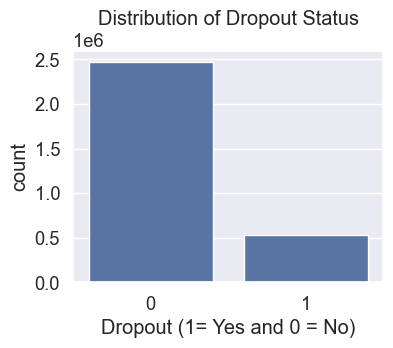

In [52]:
plt.figure(figsize = (4,3) )
sns.countplot(x= 'dropout' , data = student_df)
plt.title('Distribution of Dropout Status')
plt.xlabel('Dropout (1= Yes and 0 = No)')
plt.ylabel('count')
plt.show()

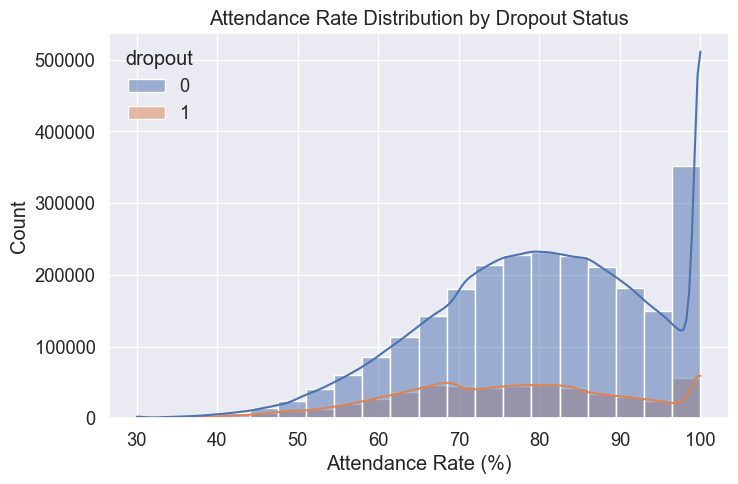

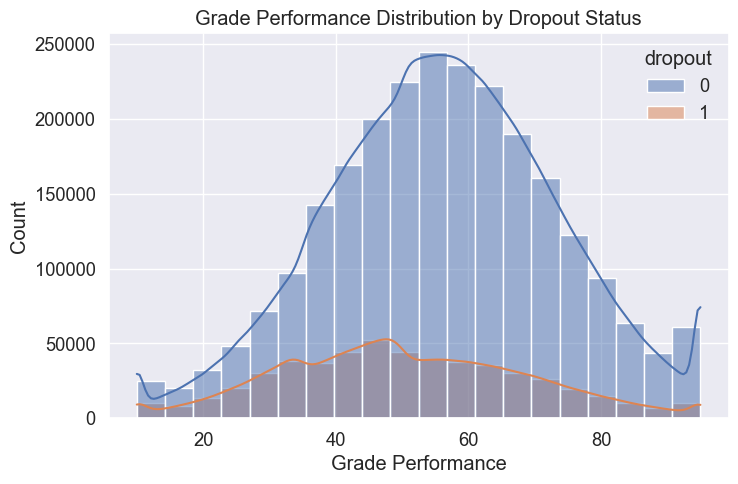

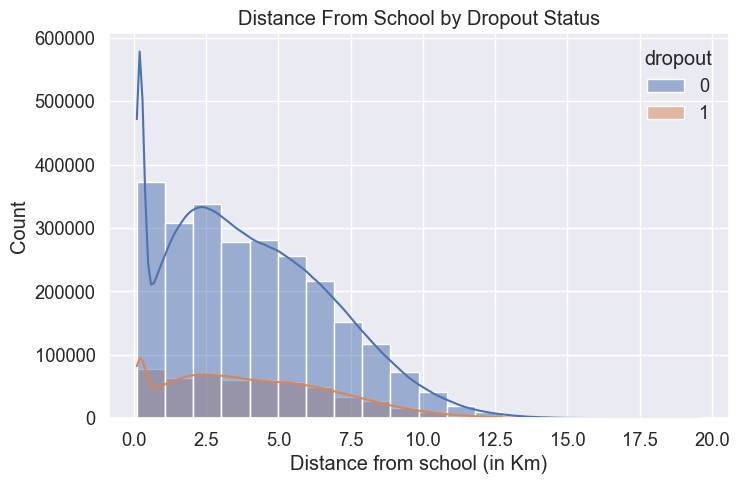

In [53]:
# Analyze attendance rate distribution
plt.figure(figsize=(8, 5))
sns.histplot(data=student_df, x='attendance_rate', hue='dropout', bins=20, kde=True)
plt.title('Attendance Rate Distribution by Dropout Status')
plt.xlabel('Attendance Rate (%)')
plt.show()

# Analyze grade performance distribution
plt.figure(figsize=(8 , 5))
sns.histplot(data=student_df, x='grade_performance', hue='dropout', bins=20, kde=True)
plt.title('Grade Performance Distribution by Dropout Status')
plt.xlabel('Grade Performance')
plt.show()

# Analyze distance to school

plt.figure(figsize = (8,5))
sns.histplot(data = student_df , x = 'distance_to_school' ,hue = 'dropout',  bins =20, kde = True)
plt.title('Distance From School by Dropout Status')
plt.xlabel('Distance from school (in Km)')
plt.show()


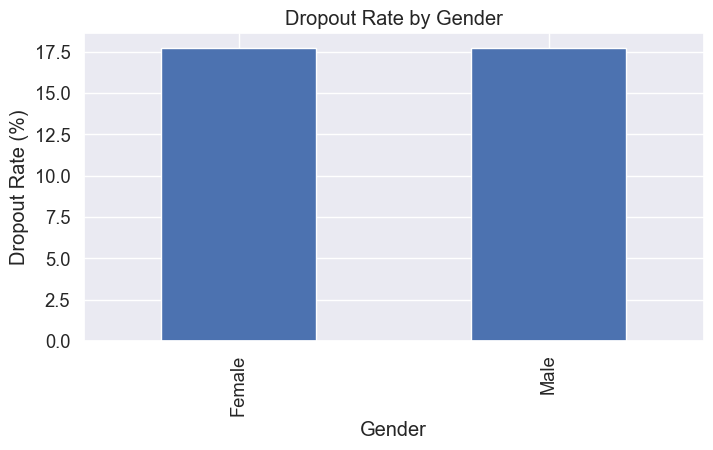

In [54]:
# Dropout rate by gender
plt.figure(figsize=(8, 4))
gender_dropout = student_df.groupby('gender')['dropout'].mean() * 100
gender_dropout.plot(kind='bar')
plt.title('Dropout Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Dropout Rate (%)')
plt.show()

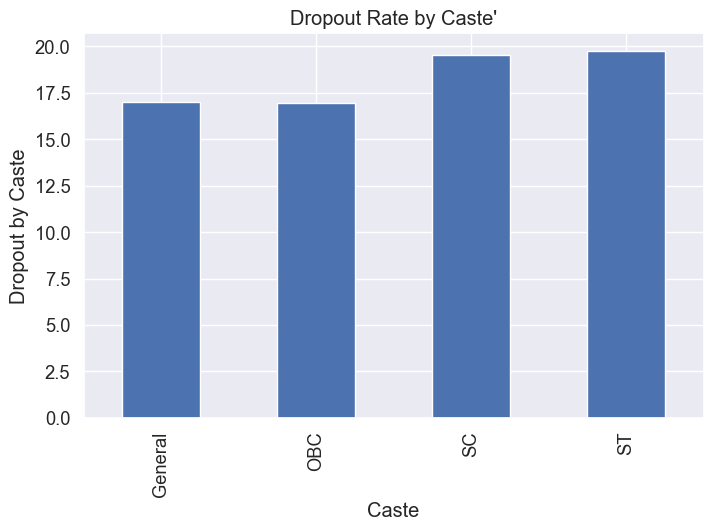

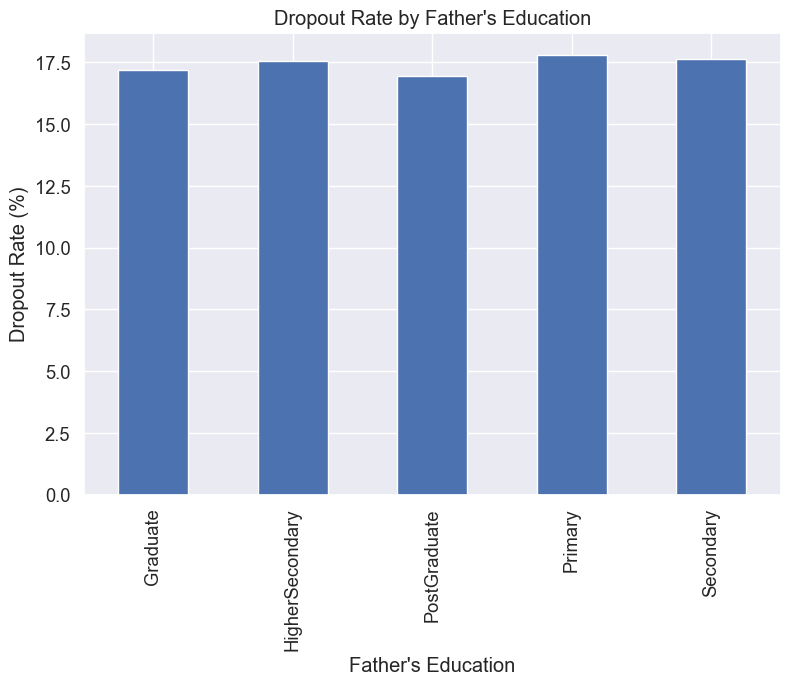

In [55]:
# Dropout rate by caste
plt.figure(figsize = (8,5))
caste_dropout = student_df.groupby('caste')['dropout'].mean()*100
caste_dropout.plot(kind = "bar")
plt.title("Dropout Rate by Caste'")
plt.xlabel('Caste')
plt.ylabel('Dropout by Caste')
plt.show()

# Dropout rate by father's education
plt.figure(figsize=(9, 6))
education_dropout = student_df.groupby('father_education')['dropout'].mean() * 100
education_dropout.plot(kind='bar')
plt.title("Dropout Rate by Father's Education")
plt.xlabel("Father's Education")
plt.ylabel('Dropout Rate (%)')
plt.show()



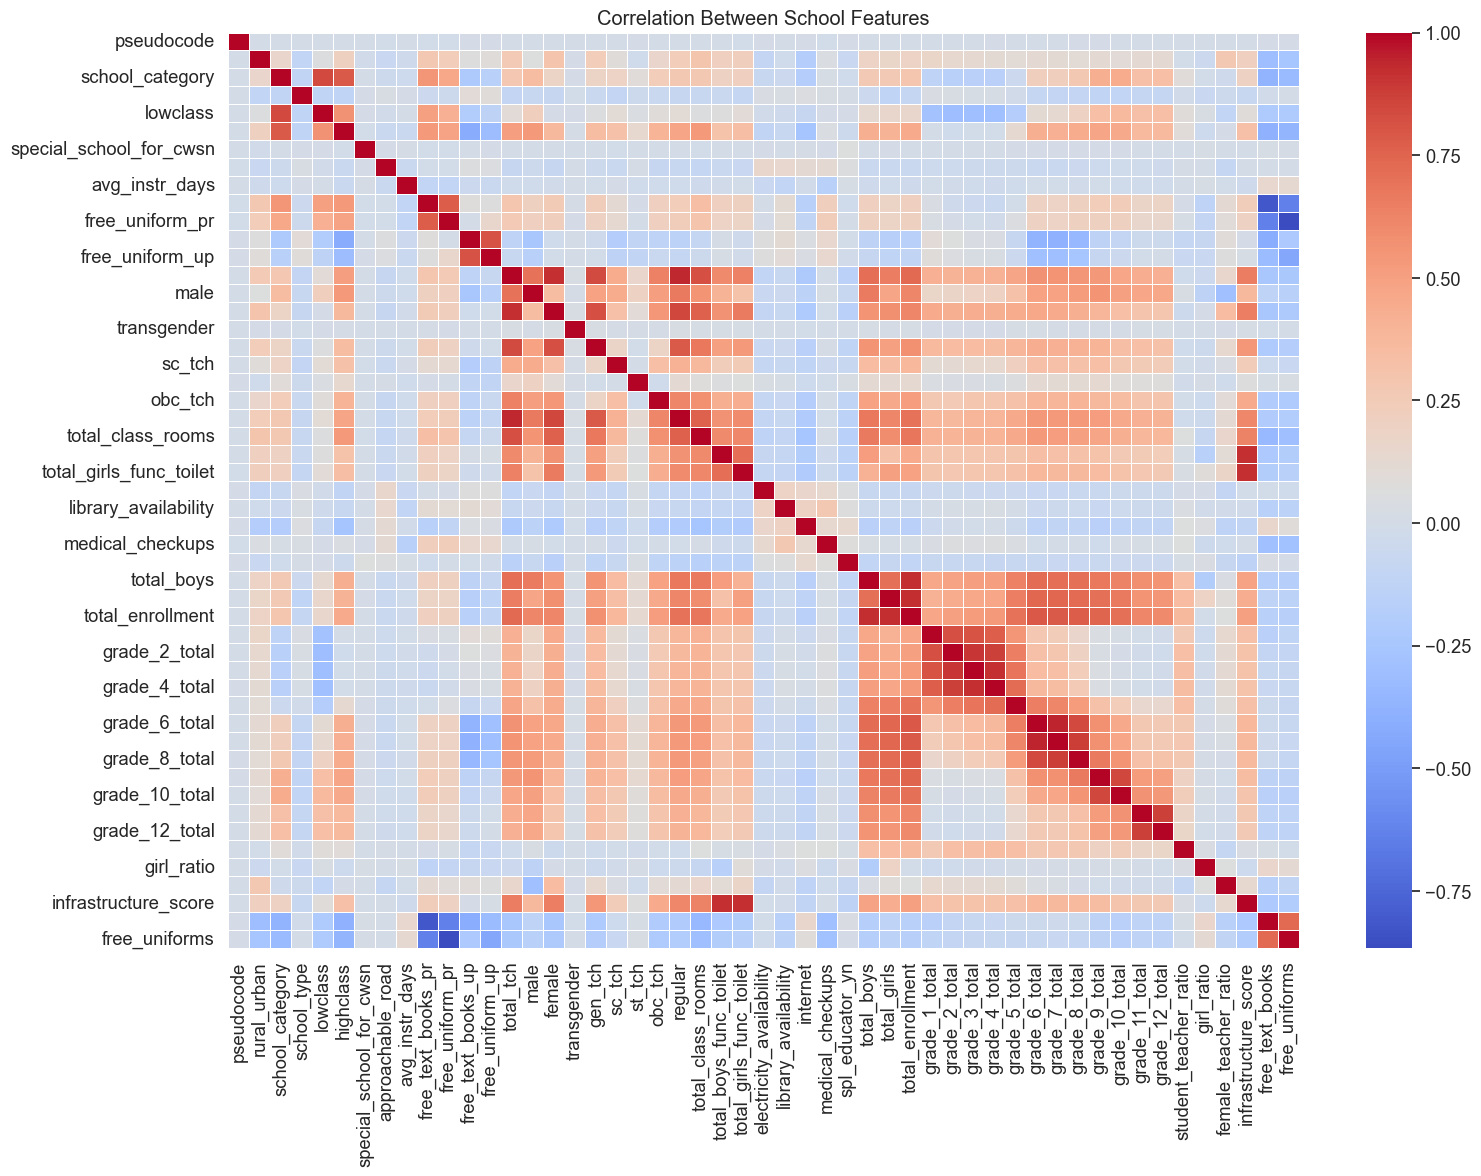

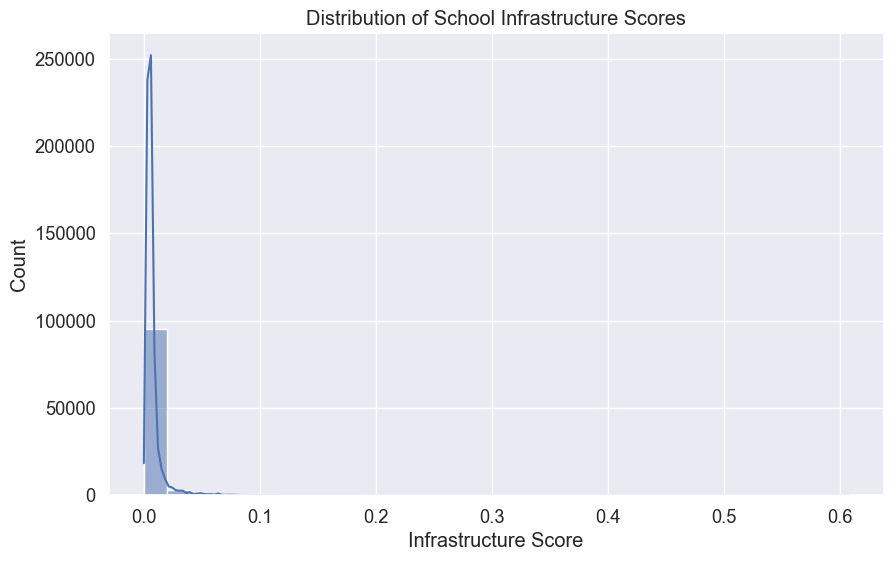

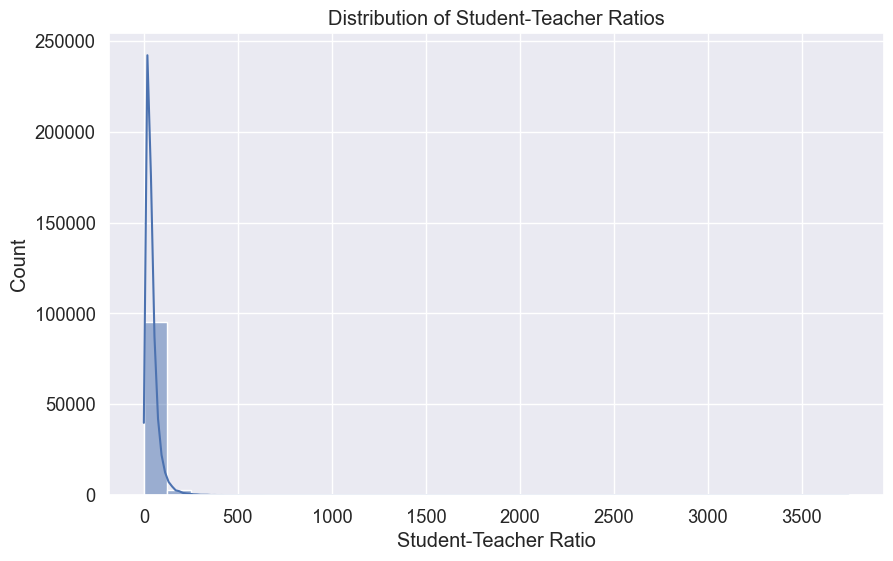

In [56]:
# Create a correlation matrix of numerical school features
school_numeric = school_df.select_dtypes(include=['float64', 'int64'])
correlation = school_numeric.corr()

# Plot heatmap of correlations
plt.figure(figsize=(16, 12))
sns.heatmap(correlation, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between School Features')
plt.tight_layout()
plt.show()

# Look at infrastructure score distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=school_df, x='infrastructure_score', bins=30, kde=True)
plt.title('Distribution of School Infrastructure Scores')
plt.xlabel('Infrastructure Score')
plt.show()

# Analyze student-teacher ratio
plt.figure(figsize=(10, 6))
sns.histplot(data=school_df, x='student_teacher_ratio', bins=30, kde=True)
plt.title('Distribution of Student-Teacher Ratios')
plt.xlabel('Student-Teacher Ratio')
plt.show()

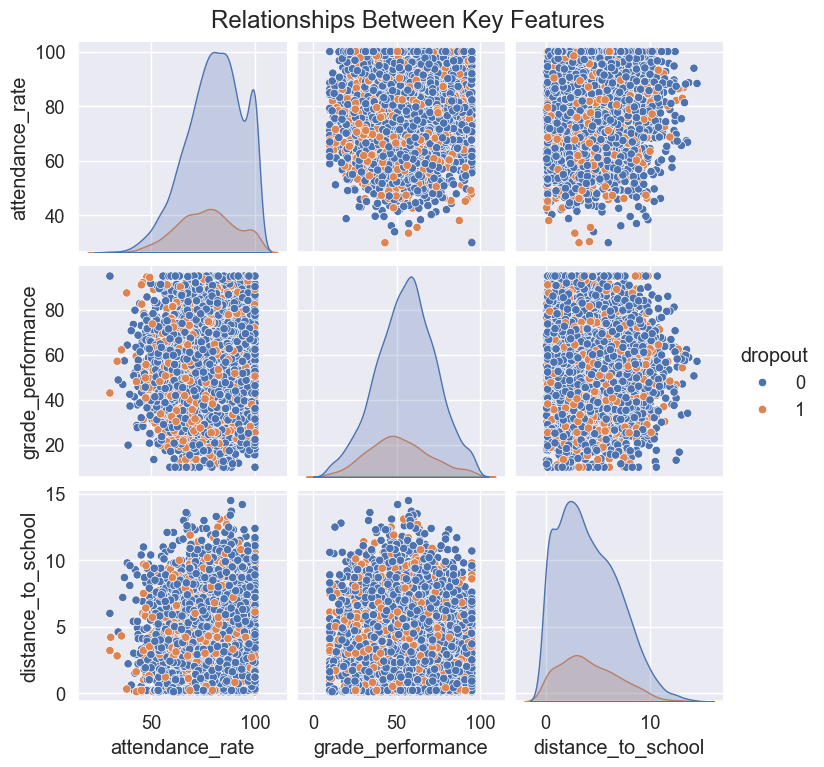

In [57]:
# Create a pairplot of important student features
important_features = ['attendance_rate', 'grade_performance', 'distance_to_school', 'dropout']

# --- Add this part to sample the data ---
# Adjust the 'n' value based on how many rows you want to sample
# A few thousand rows is usually sufficient for a pairplot
sample_size = 5000 # You can change this number
if len(student_df) > sample_size:
    student_df_sample = student_df.sample(n=sample_size, random_state=42) # random_state for reproducibility
else:
    student_df_sample = student_df # If the dataset is small, use the whole thing
# ---------------------------------------

# Use the sampled DataFrame for the pairplott
sns.pairplot(student_df_sample[important_features], hue='dropout')

plt.suptitle('Relationships Between Key Features', y=1.02)
plt.show()

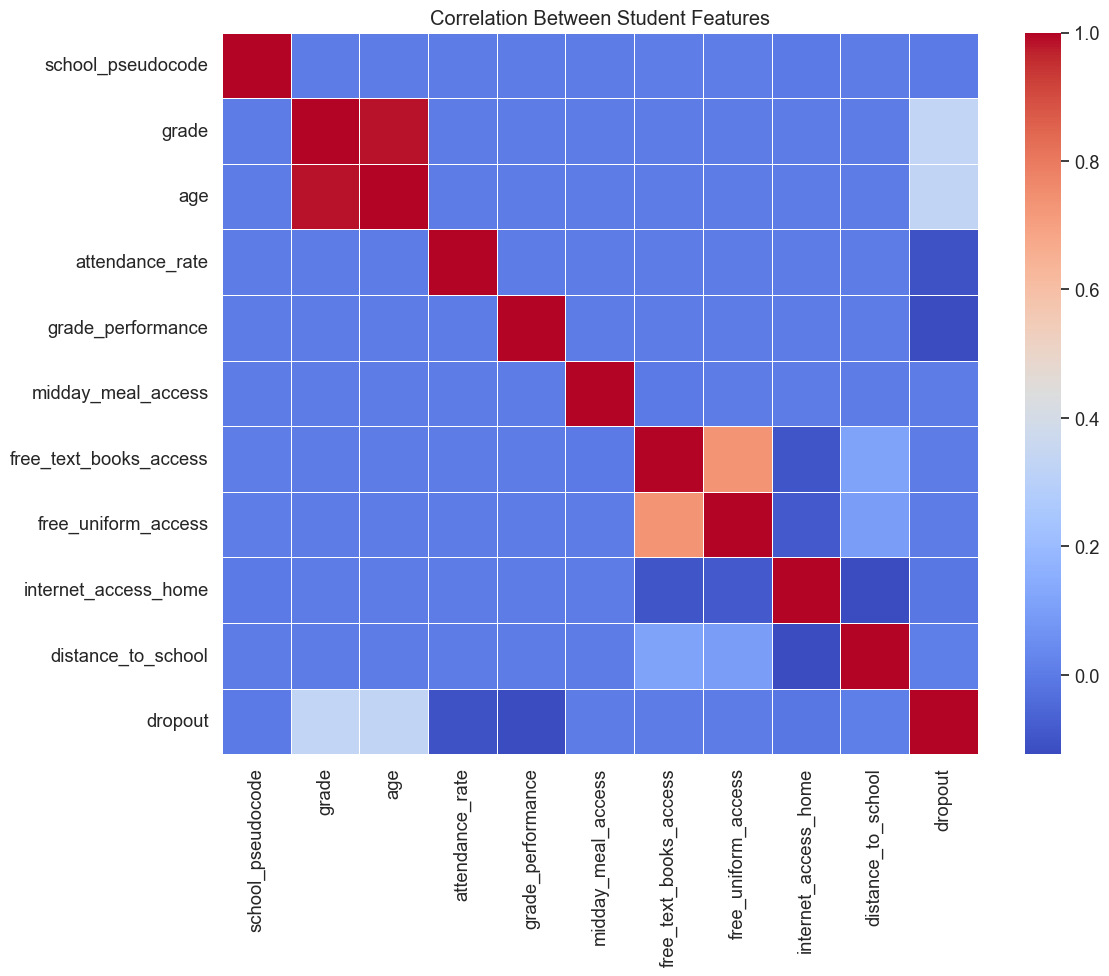

In [58]:
# Check correlation between student features
student_numeric = student_df.select_dtypes(include=['float64', 'int64'])
student_correlation = student_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(student_correlation, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between Student Features')
plt.tight_layout()
plt.show()

/var/folders/pn/2_5xrd91051d0jqmjfqcwg4m0000gn/T/ipykernel_8166/3311713241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_df.loc[:, 'rural_urban_str'] = school_df['rural_urban'].map({0: 'Urban', 1: 'Rural'})


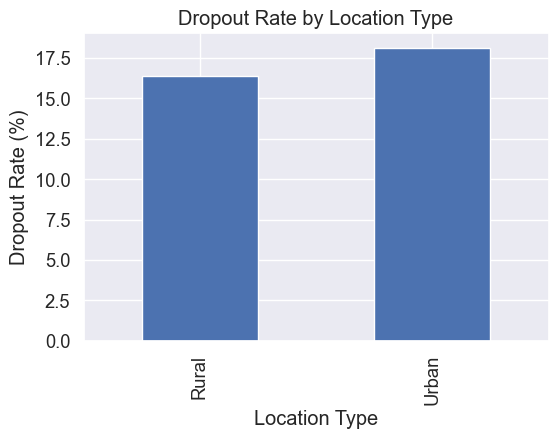

In [61]:
# Convert to string for better readability

school_df.loc[:, 'rural_urban_str'] = school_df['rural_urban'].map({0: 'Urban', 1: 'Rural'})
# Assuming student_df and school_df can be joined on school_pseudocode
sample_students = student_df.sample(min(100000, len(student_df)) , random_state=42)
sample_with_school = sample_students.merge(
    school_df[['pseudocode', 'rural_urban_str','infrastructure_score']], 
    left_on='school_pseudocode', 
    right_on='pseudocode', 
    how='left'
)

# Compare dropout rates by rural/urban
plt.figure(figsize=(6, 4))
urban_rural_dropout = sample_with_school.groupby('rural_urban_str')['dropout'].mean() * 100
urban_rural_dropout.plot(kind='bar')
plt.title('Dropout Rate by Location Type')
plt.xlabel('Location Type')
plt.ylabel('Dropout Rate (%)')
plt.show()

In [62]:
student_df['dropout'].mean()*100

17.713766666666668

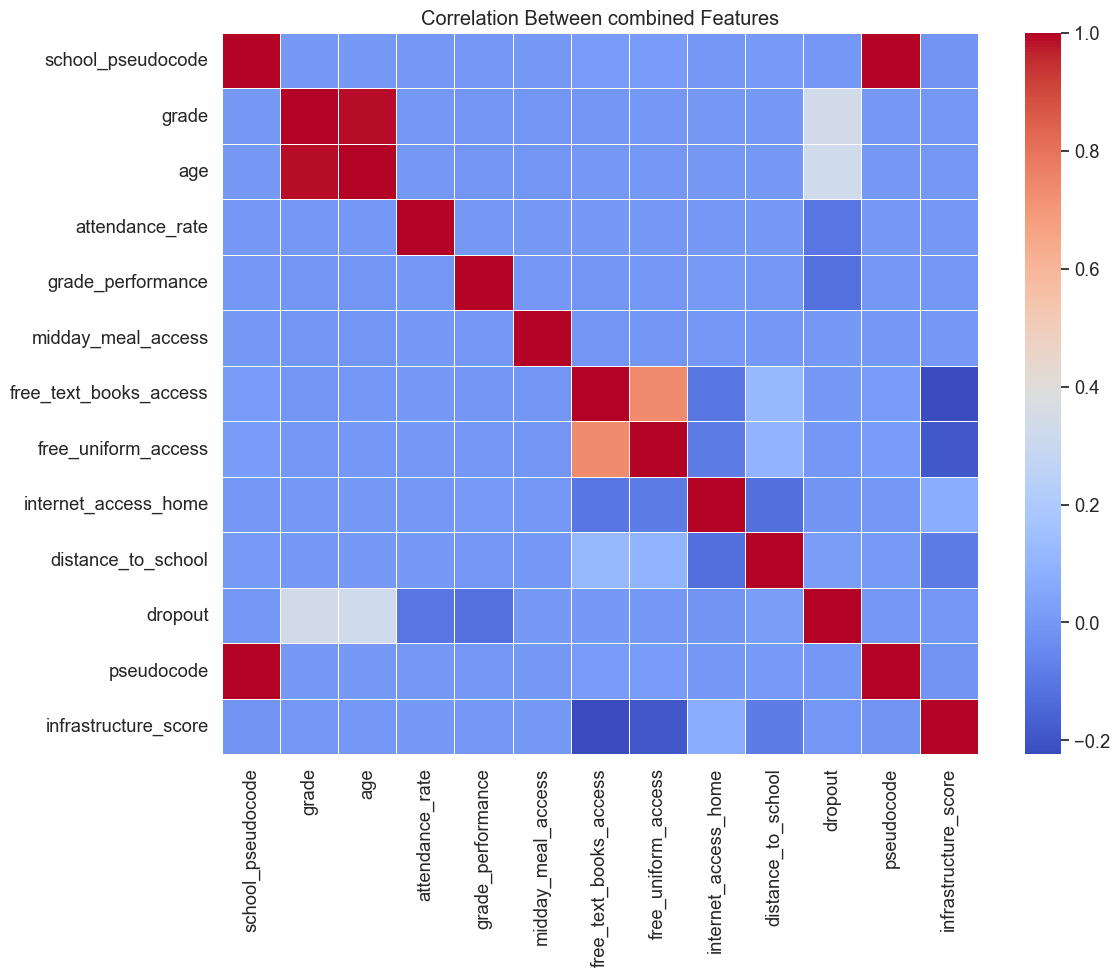

In [64]:
# Check correlation between student features
combined_numeric = sample_with_school.select_dtypes(include=['float64', 'int64'])
combined_correlation = combined_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(combined_correlation, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between combined Features')
plt.tight_layout()
plt.show()

/var/folders/pn/2_5xrd91051d0jqmjfqcwg4m0000gn/T/ipykernel_8166/1157960118.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Caste', y='Dropout Rate (%)', data=caste_dropout, palette='viridis')


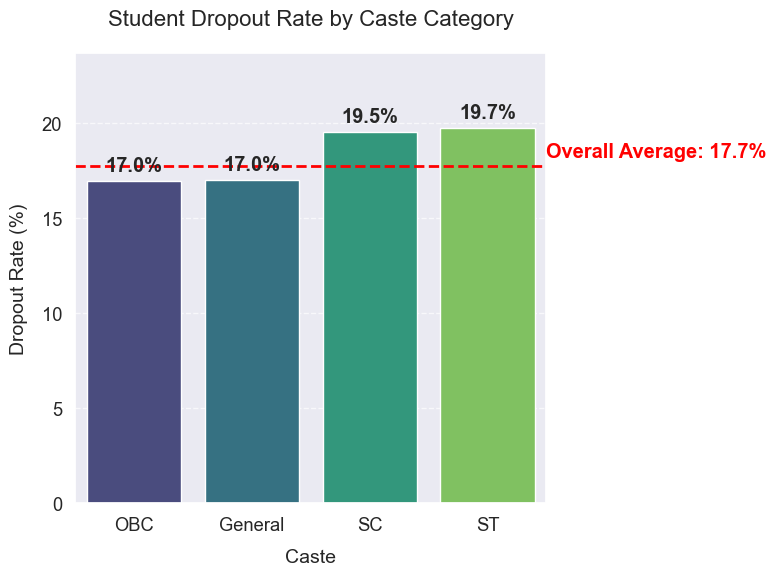

In [65]:

# Dropout rate by caste
caste_dropout = student_df.groupby('caste')['dropout'].mean() * 100
caste_dropout = caste_dropout.reset_index()
caste_dropout.columns = ['Caste', 'Dropout Rate (%)']

# Sort by dropout rate for better visualization
caste_dropout = caste_dropout.sort_values('Dropout Rate (%)', ascending=True)

# Create the bar plot
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='Caste', y='Dropout Rate (%)', data=caste_dropout, palette='viridis')

# Add value labels on top of each bar
for i, value in enumerate(caste_dropout['Dropout Rate (%)']):
    bar_plot.text(i, value + 0.5, f'{value:.1f}%', ha='center', fontweight='bold')

# Customize the plot
plt.title('Student Dropout Rate by Caste Category', fontsize=16, pad=20)
plt.xlabel('Caste', fontsize=14, labelpad=10)
plt.ylabel('Dropout Rate (%)', fontsize=14, labelpad=10)
plt.xticks(rotation=0)
plt.ylim(0, max(caste_dropout['Dropout Rate (%)']) * 1.2)  # Add some space above bars for labels
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add overall average line
overall_dropout_rate = student_df['dropout'].mean() * 100
plt.axhline(y=overall_dropout_rate, color='red', linestyle='--', linewidth=2)
plt.text(len(caste_dropout) - 0.5, overall_dropout_rate + 0.5, 
         f'Overall Average: {overall_dropout_rate:.1f}%', 
         color='red', fontweight='bold')

plt.tight_layout()
plt.savefig('dropout_by_caste.png', dpi=300)
plt.show()




/var/folders/pn/2_5xrd91051d0jqmjfqcwg4m0000gn/T/ipykernel_8166/2750192449.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Family Income', y='Dropout Rate (%)', data=income_dropout, palette='plasma')
/var/folders/pn/2_5xrd91051d0jqmjfqcwg4m0000gn/T/ipykernel_8166/2750192449.py:32: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/pn/2_5xrd91051d0jqmjfqcwg4m0000gn/T/ipykernel_8166/2750192449.py:33: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Arial.
  plt.savefig('dropout_by_income.png', dpi=300)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


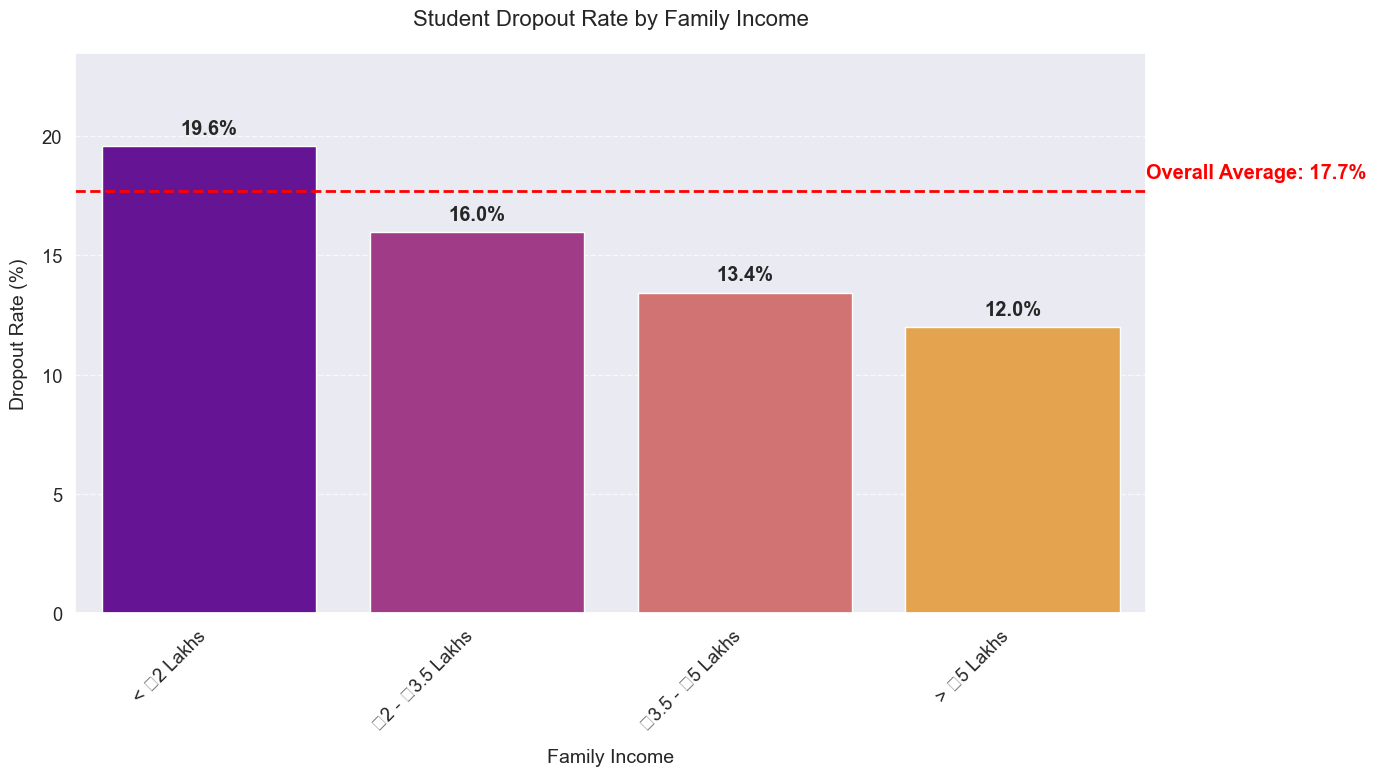

In [66]:

# Dropout rate by family income
# Calculate dropout percentage by family income
income_dropout = student_df.groupby('family_income')['dropout'].mean() * 100
income_dropout = income_dropout.reset_index()
income_dropout.columns = ['Family Income', 'Dropout Rate (%)']

# Sort by dropout rate if not using ordered categories
income_dropout = income_dropout.sort_values('Dropout Rate (%)', ascending=False)

# Create the bar plot
plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(x='Family Income', y='Dropout Rate (%)', data=income_dropout, palette='plasma')

# Add value labels on top of each bar
for i, value in enumerate(income_dropout['Dropout Rate (%)']):
    bar_plot.text(i, value + 0.5, f'{value:.1f}%', ha='center', fontweight='bold')

# Customize the plot
plt.title('Student Dropout Rate by Family Income', fontsize=16, pad=20)
plt.xlabel('Family Income', fontsize=14, labelpad=10)
plt.ylabel('Dropout Rate (%)', fontsize=14, labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(income_dropout['Dropout Rate (%)']) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add overall average line
plt.axhline(y=overall_dropout_rate, color='red', linestyle='--', linewidth=2)
plt.text(len(income_dropout) - 0.5, overall_dropout_rate + 0.5, 
         f'Overall Average: {overall_dropout_rate:.1f}%', 
         color='red', fontweight='bold')

plt.tight_layout()
plt.savefig('dropout_by_income.png', dpi=300)
plt.show()


/var/folders/pn/2_5xrd91051d0jqmjfqcwg4m0000gn/T/ipykernel_8166/943479980.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='Father\'s Education', y='Dropout Rate (%)',


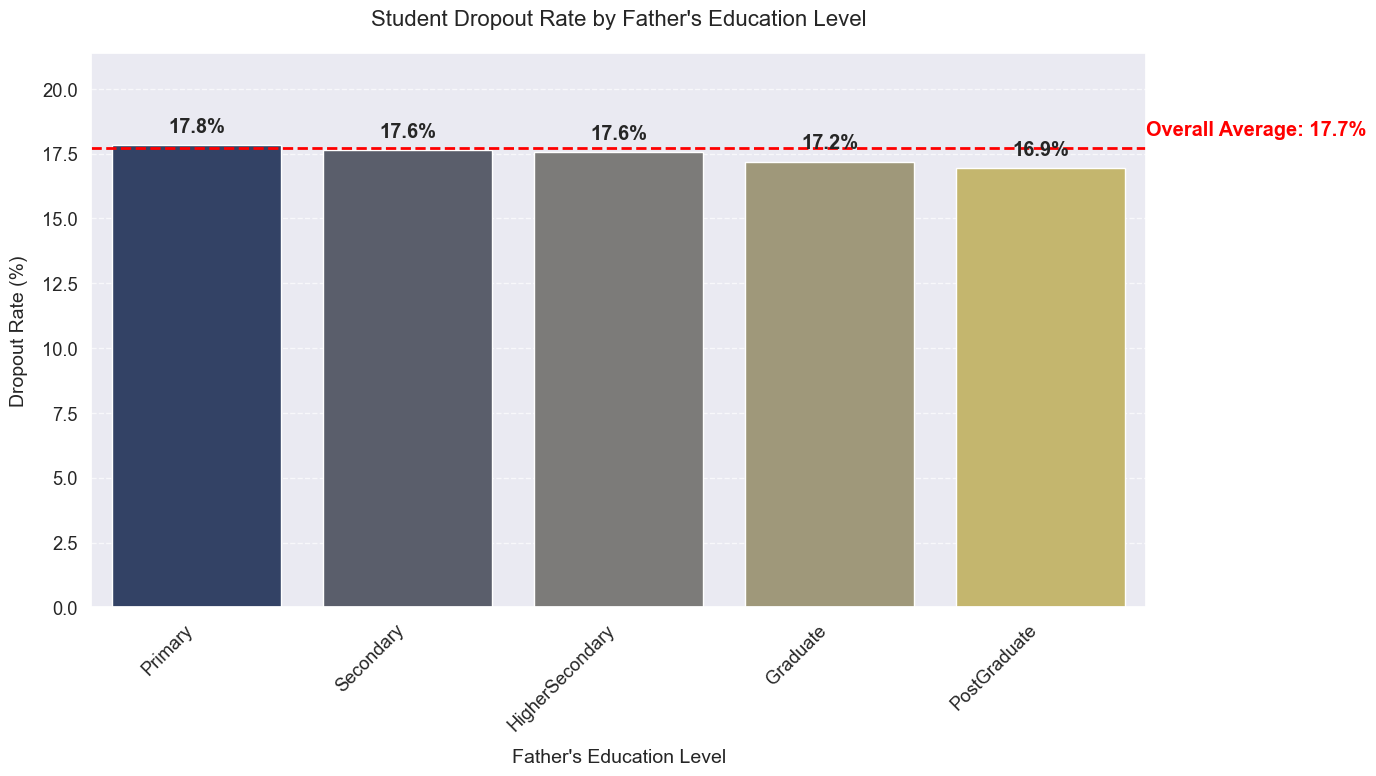

In [67]:

# 3. Dropout rate by father's education
# Calculate dropout percentage by father's education level
education_dropout = student_df.groupby('father_education')['dropout'].mean() * 100
education_dropout = education_dropout.reset_index()
education_dropout.columns = ['Father\'s Education', 'Dropout Rate (%)']

# Sort by dropout rate if not using ordered categories
education_dropout = education_dropout.sort_values('Dropout Rate (%)', ascending=False)

# Create the bar plot with a different color scheme
plt.figure(figsize=(14, 8))
bar_plot = sns.barplot(x='Father\'s Education', y='Dropout Rate (%)', 
                      data=education_dropout, palette='cividis')

# Add value labels on top of each bar
for i, value in enumerate(education_dropout['Dropout Rate (%)']):
    bar_plot.text(i, value + 0.5, f'{value:.1f}%', ha='center', fontweight='bold')

# Customize the plot
plt.title('Student Dropout Rate by Father\'s Education Level', fontsize=16, pad=20)
plt.xlabel('Father\'s Education Level', fontsize=14, labelpad=10)
plt.ylabel('Dropout Rate (%)', fontsize=14, labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(education_dropout['Dropout Rate (%)']) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add overall average line
plt.axhline(y=overall_dropout_rate, color='red', linestyle='--', linewidth=2)
plt.text(len(education_dropout) - 0.5, overall_dropout_rate + 0.5, 
         f'Overall Average: {overall_dropout_rate:.1f}%', 
         color='red', fontweight='bold')

plt.tight_layout()
plt.savefig('dropout_by_father_education.png', dpi=300)
plt.show()



/var/folders/pn/2_5xrd91051d0jqmjfqcwg4m0000gn/T/ipykernel_8166/2870458158.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Caste', y='Dropout Rate (%)', data=caste_dropout, ax=axes[0], palette='viridis')
/var/folders/pn/2_5xrd91051d0jqmjfqcwg4m0000gn/T/ipykernel_8166/2870458158.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Family Income', y='Dropout Rate (%)', data=income_dropout, ax=axes[1], palette='plasma')
/var/folders/pn/2_5xrd91051d0jqmjfqcwg4m0000gn/T/ipykernel_8166/2870458158.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  

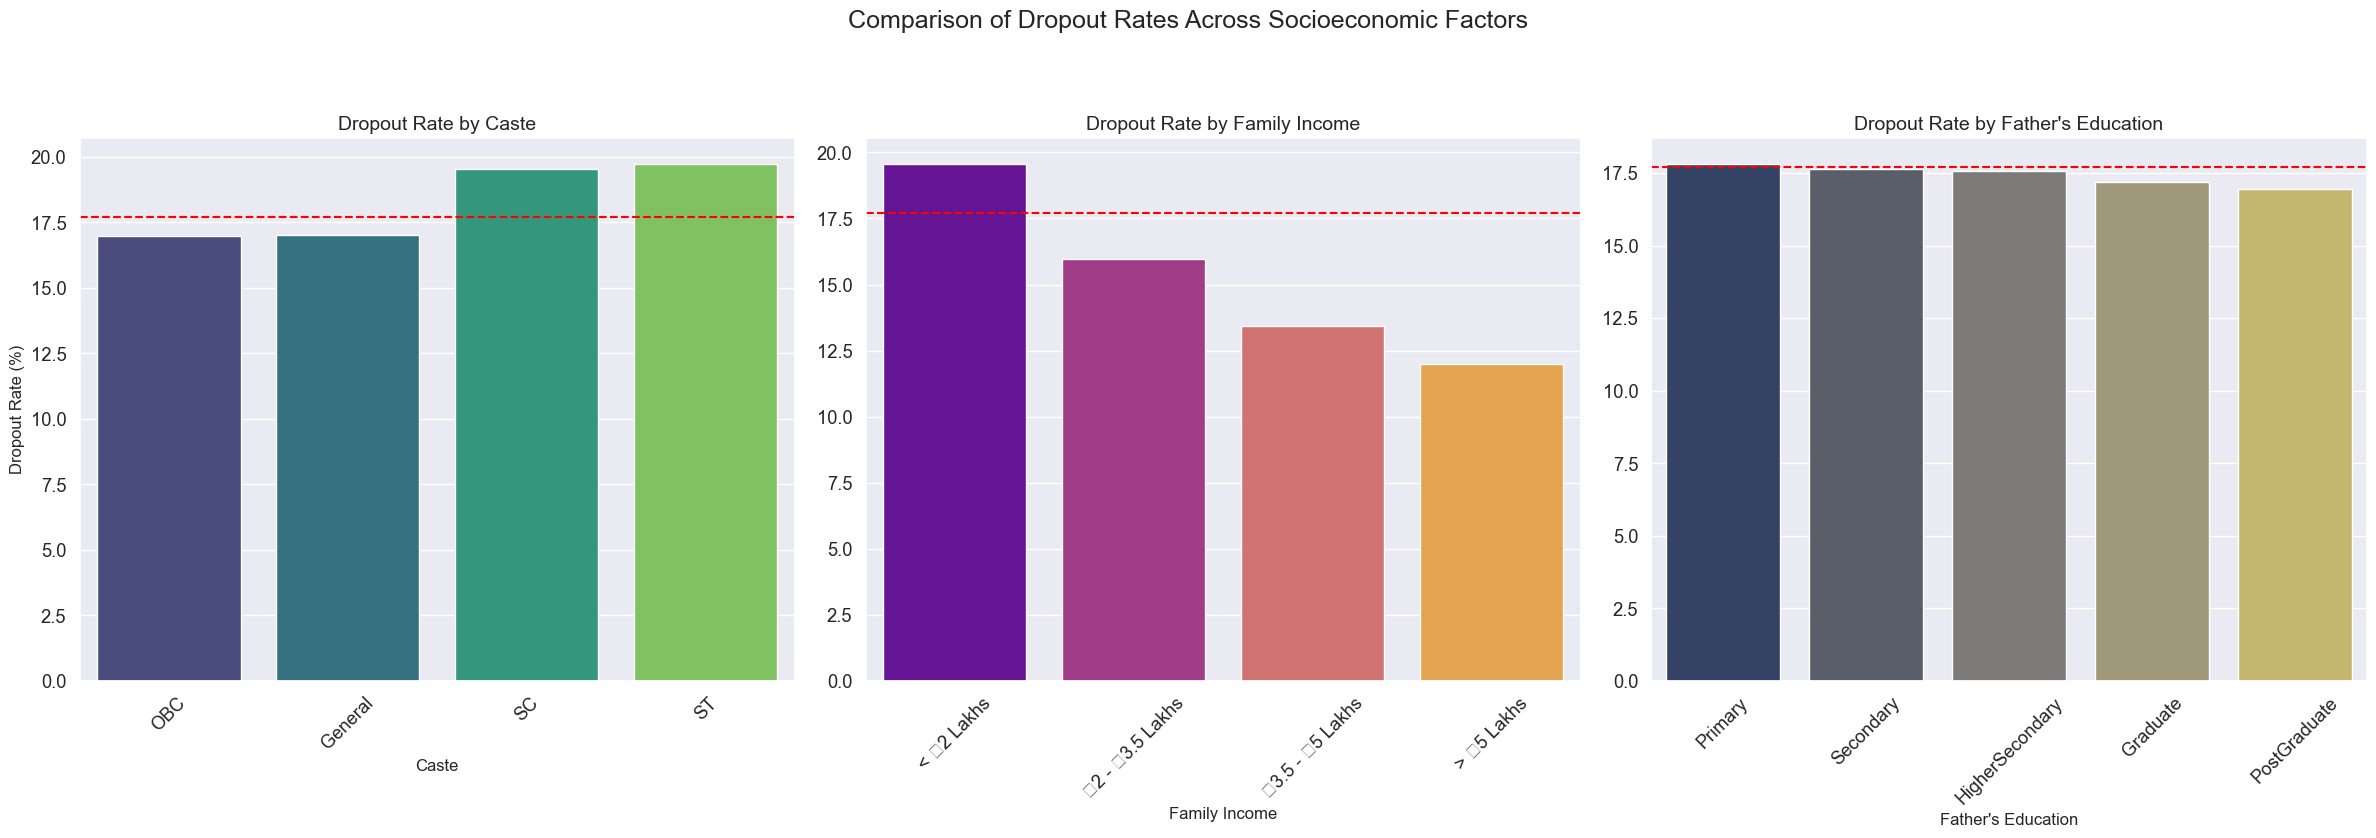

In [68]:

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Plot dropout by caste
sns.barplot(x='Caste', y='Dropout Rate (%)', data=caste_dropout, ax=axes[0], palette='viridis')
axes[0].set_title('Dropout Rate by Caste', fontsize=14)
axes[0].set_xlabel('Caste', fontsize=12)
axes[0].set_ylabel('Dropout Rate (%)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].axhline(y=overall_dropout_rate, color='red', linestyle='--')

# Plot dropout by family income
sns.barplot(x='Family Income', y='Dropout Rate (%)', data=income_dropout, ax=axes[1], palette='plasma')
axes[1].set_title('Dropout Rate by Family Income', fontsize=14)
axes[1].set_xlabel('Family Income', fontsize=12)
axes[1].set_ylabel('', fontsize=12)  # No need to repeat y-label
axes[1].tick_params(axis='x', rotation=45)
axes[1].axhline(y=overall_dropout_rate, color='red', linestyle='--')

# Plot dropout by father's education
sns.barplot(x='Father\'s Education', y='Dropout Rate (%)', data=education_dropout, ax=axes[2], palette='cividis')
axes[2].set_title('Dropout Rate by Father\'s Education', fontsize=14)
axes[2].set_xlabel('Father\'s Education', fontsize=12)
axes[2].set_ylabel('', fontsize=12)  # No need to repeat y-label
axes[2].tick_params(axis='x', rotation=45)
axes[2].axhline(y=overall_dropout_rate, color='red', linestyle='--')

# Add a main title
fig.suptitle('Comparison of Dropout Rates Across Socioeconomic Factors', fontsize=18, y=1.05)

plt.tight_layout()
plt.savefig('dropout_socioeconomic_comparison.png', dpi=300)
plt.show()


1. Average dropout rate is 17.6%, with higher rates among students with higher grades and ages 
2. Attendance rate and grade performance shows strong negative correlation with dropout (r = X)
3. Students with access to internet at home, having access to free uniforms, mid-day meals and short distances from school have lower dropout rates, hence the inverse relationship with dropout rate.
4. Students with family income below 3.5 lakhs have more than 5% higher dropout rates compared to higher income groups

5. Father's education has sizeable impact only after he has done higher secondary education and above
6. Difference between dropout rate of students belonging to ST and SC categories is 4% higher than those belonging to OBC and General
7. Key risk factors appear to be: Attendance rate, grade performance , age, grade ,caste, family income, infrastructure score, along with shorter distances from school, free uniforms and other such school facilities among others

In [69]:
student_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   school_pseudocode       int64  
 1   state                   object 
 2   district                object 
 3   rural_urban             object 
 4   grade                   int64  
 5   age                     int64  
 6   gender                  object 
 7   caste                   object 
 8   father_education        object 
 9   family_income           object 
 10  attendance_rate         float64
 11  grade_performance       float64
 12  midday_meal_access      int64  
 13  free_text_books_access  int64  
 14  free_uniform_access     int64  
 15  internet_access_home    int64  
 16  distance_to_school      float64
 17  dropout                 int64  
dtypes: float64(3), int64(8), object(7)
memory usage: 412.0+ MB


In [70]:
student_df['midday_meal_access'].value_counts()

midday_meal_access
1    2939715
0      60285
Name: count, dtype: int64

In [71]:
def create_socioeconomic_index(df):
    """
    Create a socioeconomic index by combining family income, father's education, and caste.
    Higher index values indicate better socioeconomic status.
    """
    # Map income categories to numerical values
    income_map = {
        '< ₹2 Lakhs ': 1,
        '₹2 - ₹3.5 Lakhs': 2, 
        '₹3.5 - ₹5 Lakhs': 4,
        '> ₹5 Lakhs': 6
    }
    
    # Map education categories to numerical values
    education_map = {
        'None': 1,
        'Primary': 2,
        'Secondary': 3,
        'HigherSecondary': 4,
        'Graduate': 5,
        'PostGraduate': 6
    }
    
    # Map caste categories to numerical values based on your findings
    # EDA showed higher dropout in SC/ST, so we assign lower values
    caste_map = {
        'ST': 1,  # Highest dropout rate 
        'SC': 2,
        'OBC': 3,
        'General': 4  # Lowest dropout rate
    }
    
    # Create individual component scores
    # Handle missing values or categories not in the mapping
    df['income_score'] = df['family_income'].map(income_map).fillna(1)
    df['education_score'] = df['father_education'].map(education_map).fillna(1)
    df['caste_score'] = df['caste'].map(caste_map).fillna(1)
    
    # Normalize each component to 0-1 scale
    for col in ['income_score', 'education_score', 'caste_score']:
        min_val = df[col].min()
        max_val = df[col].max()
        df[f'{col}_norm'] = (df[col] - min_val) / (max_val - min_val)
    
    # Create weighted socioeconomic index
    # Weights based on your EDA findings - adjust as needed
    df['socioeconomic_index'] = (
        0.5 * df['income_score_norm'] + 
        0.15 * df['education_score_norm'] + 
        0.35 * df['caste_score_norm']
    )
    
    # Scale to 0-100 for easier interpretation
    df['socioeconomic_index'] = df['socioeconomic_index'] * 100

    # dropping intermediate columns 
    df = df.drop(['income_score', 'education_score', 'caste_score', 
                 'income_score_norm', 'education_score_norm', 'caste_score_norm'], axis=1)
    
    return df

In [72]:
def create_school_support_score(df):
    """
    Create a school support score by combining midday meals, free uniforms, and textbooks access.
    Higher score indicates better support.
    """
    # Ensure all components are binary (0 or 1)
    support_columns = ['midday_meal_access', 'free_text_books_access', 'free_uniform_access']
    
    # Create simple sum of support features (each feature has equal weight)
    df['school_support_score'] = df[support_columns].sum(axis=1)
    
    # Normalize to 0-100 scale
    df['school_support_score'] = (df['school_support_score'] / len(support_columns)) * 100
    
    return df


def create_accessibility_score(df):
    """
    Transform distance to school into an accessibility score using exponential decay.
    Higher score indicates better accessibility (shorter distance).
    """

    # Parameters for the exponential decay function
    # This parameter controls how quickly the score decreases with distance
    # A higher value makes the score drop more quickly with distance
    decay_rate = 0.5
    
    # Apply exponential decay function
    # This converts distances to scores where:
    # - Short distances get scores close to 100
    # - Long distances get scores close to 0
    df['accessibility_score'] = 100 * np.exp(-decay_rate * df['distance_to_school'])
    
    return df

In [73]:
school_df['highclass'].value_counts()

highclass
5     42913
8     25576
12    10884
10     9869
4      6701
7      3537
6       172
2       158
3        65
9        59
11       45
0        12
1         9
Name: count, dtype: int64

In [74]:
student_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   school_pseudocode       int64  
 1   state                   object 
 2   district                object 
 3   rural_urban             object 
 4   grade                   int64  
 5   age                     int64  
 6   gender                  object 
 7   caste                   object 
 8   father_education        object 
 9   family_income           object 
 10  attendance_rate         float64
 11  grade_performance       float64
 12  midday_meal_access      int64  
 13  free_text_books_access  int64  
 14  free_uniform_access     int64  
 15  internet_access_home    int64  
 16  distance_to_school      float64
 17  dropout                 int64  
dtypes: float64(3), int64(8), object(7)
memory usage: 412.0+ MB


In [75]:
def merge_student_school_data(student_df, school_df):
    """
    Merge student and school datasets to create a comprehensive dataset for modeling.
    """
    school_features = [
        'pseudocode', 'rural_urban', 'school_category', 'school_type', 'avg_instr_days', 'medical_checkups',
        'student_teacher_ratio', 'girl_ratio', 'female_teacher_ratio', 'infrastructure_score'
    ]
    
    # Create simplified school dataframe with selected features
    school_df_simple = school_df[school_features].copy()
    
    # Rename the key column in school_df to match student_df
    school_df_simple = school_df_simple.rename(columns={'pseudocode': 'school_pseudocode'})
    
    # Merge datasets
    combined_df = student_df.merge(
        school_df_simple,
        on='school_pseudocode',
        how='left'  # Keep all students, even if school data is missing
    )
    
    # Check for missing values after merge
    missing_count = combined_df.isnull().sum()
    print("Missing values after merge:")
    print(missing_count[missing_count > 0])
    
    # Fill missing values from school data (if any)
    # For numeric columns, use median
    numeric_cols = combined_df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        if combined_df[col].isnull().sum() > 0:
            combined_df[col] = combined_df[col].fillna(combined_df[col].median())
    
    # For categorical columns, use most frequent value
    cat_cols = combined_df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if combined_df[col].isnull().sum() > 0:
            combined_df[col] = combined_df[col].fillna(combined_df[col].mode()[0])
    
    return combined_df

In [76]:

def preprocess_data_for_modeling(student_df, school_df):
    """
    Complete preprocessing pipeline that:
    1. Merges student and school data
    2. Creates composite features
    3. Handles missing values and outliers
    4. Prepares data for modeling
    """
    print("Starting data preprocessing pipeline...")
    print(f"Initial student data shape: {student_df.shape}")
    print(f"Initial school data shape: {school_df.shape}")
    
    # Step 1: Merge datasets
    print("\nMerging student and school datasets...")
    combined_df = merge_student_school_data(student_df, school_df)
    print(f"Combined data shape: {combined_df.shape}")
    
    # Step 2: Create composite features
    print("\nCreating socioeconomic index...")
    combined_df = create_socioeconomic_index(combined_df)
    
    print("Creating school support score...")
    combined_df = create_school_support_score(combined_df)
    
    print("Creating accessibility score...")
    combined_df = create_accessibility_score(combined_df)
    
    # Step 3: Create additional derived features
    print("\nCreating additional features...")
    
    # Age-grade mismatch (students who are older than expected for their grade)
    # Expected age for each grade (adjust based on your educational system)
    expected_age = {
        1: 6, 2: 7, 3: 8, 4: 9, 5: 10, 
        6: 11, 7: 12, 8: 13, 9: 14, 10: 15,
        11: 16, 12: 17
    }
    
    # Calculate age difference from expected
    combined_df['expected_age'] = combined_df['grade'].map(expected_age)
    combined_df['age_grade_diff'] = combined_df['age'] - combined_df['expected_age']
    combined_df['age_grade_mismatch'] = (combined_df['age_grade_diff'] > 1).astype(int)
    
    # Categorize attendance into risk bands
    combined_df['attendance_risk'] = pd.cut(
        combined_df['attendance_rate'],
        bins=[0, 60, 80, 100],
        labels=['High Risk', 'Medium Risk', 'Low Risk']
    )
    
    # Create binary indicators for high-impact factors (based on your EDA)
    combined_df['low_attendance'] = (combined_df['attendance_rate'] < 70).astype(int)
    combined_df['low_grades'] = (combined_df['grade_performance'] < 50).astype(int)
    combined_df['high_distance'] = (combined_df['distance_to_school'] > 5).astype(int)
    
    # Step 4: Handle any remaining missing values
    print("\nHandling missing values...")
    
    # Check for missing values
    missing_count = combined_df.isnull().sum()
    print("Columns with missing values:")
    print(missing_count[missing_count > 0])
    
    # For any remaining missing values, apply appropriate imputation
    # Numeric columns - median imputation
    numeric_cols = combined_df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        if combined_df[col].isnull().sum() > 0:
            combined_df[col] = combined_df[col].fillna(combined_df[col].median())
    
    # Categorical columns - mode imputation
    cat_cols = combined_df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if combined_df[col].isnull().sum() > 0:
            combined_df[col] = combined_df[col].fillna(combined_df[col].mode()[0])
    
    # Step 5: Handle outliers for key numeric variables
    print("\nHandling outliers...")
    
    # Define columns to check for outliers
    outlier_columns = ['attendance_rate', 'grade_performance', 'distance_to_school']
    
    # Cap outliers at 1.5 * IQR
    for col in outlier_columns:
        Q1 = combined_df[col].quantile(0.25)
        Q3 = combined_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        outliers = ((combined_df[col] < lower_bound) | (combined_df[col] > upper_bound)).sum()
        print(f"Column {col}: {outliers} outliers detected and capped")
        
        # Cap outliers
        combined_df[col] = np.where(
            combined_df[col] < lower_bound,
            lower_bound,
            np.where(
                combined_df[col] > upper_bound,
                upper_bound,
                combined_df[col]
            )
        )
    

    # We'll leave the actual encoding for the modeling notebook
    # Just identify categorical columns that need encoding
    categorical_columns = combined_df.select_dtypes(include=['object', 'category']).columns.tolist()
    print(f"Categorical columns that need encoding: {categorical_columns}")

    print("\nPreprocessing complete!")
    print(f"Final dataset shape: {combined_df.shape}")
    
    
    # Return the preprocessed dataframe
    return combined_df

In [77]:

# Run the preprocessing pipeline
preprocessed_df = preprocess_data_for_modeling(student_df, school_df)

# Display sample of the processed data
print("\nSample of preprocessed data:")
display(preprocessed_df.head())

# Summarize the new features
print("\nSummary of newly created features:")
new_features = ['socioeconomic_index', 'school_support_score', 'accessibility_score', 
                'age_grade_mismatch', 'attendance_risk']
display(preprocessed_df[new_features].describe())


Starting data preprocessing pipeline...
Initial student data shape: (3000000, 18)
Initial school data shape: (100000, 55)

Merging student and school datasets...
Missing values after merge:
father_education         899665
student_teacher_ratio     26130
girl_ratio                26130
female_teacher_ratio      27750
dtype: int64
Combined data shape: (3000000, 27)

Creating socioeconomic index...
Creating school support score...
Creating accessibility score...

Creating additional features...

Handling missing values...
Columns with missing values:
Series([], dtype: int64)

Handling outliers...
Column attendance_rate: 10663 outliers detected and capped
Column grade_performance: 0 outliers detected and capped
Column distance_to_school: 13240 outliers detected and capped
Categorical columns that need encoding: ['state', 'district', 'rural_urban_x', 'gender', 'caste', 'father_education', 'family_income', 'attendance_risk']

Preprocessing complete!
Final dataset shape: (3000000, 37)

Sample

,school_pseudocode,state,district,rural_urban_x,grade,age,gender,caste,father_education,family_income,...,socioeconomic_index,school_support_score,accessibility_score,expected_age,age_grade_diff,age_grade_mismatch,attendance_risk,low_attendance,low_grades,high_distance
0,9159944,ANDHRA PRADESH,KRISHNA,Rural,1,6,Male,OBC,Primary,< ₹2 Lakhs,...,23.333333,100.0,34.993775,6,0,0,High Risk,1,0,0
1,9159944,ANDHRA PRADESH,KRISHNA,Rural,6,11,Male,SC,HigherSecondary,< ₹2 Lakhs,...,19.166667,100.0,0.551656,11,0,0,Medium Risk,0,0,1
2,9159944,ANDHRA PRADESH,KRISHNA,Rural,7,12,Male,OBC,Graduate,₹2 - ₹3.5 Lakhs,...,44.583333,100.0,25.924026,12,0,0,Medium Risk,0,0,0
3,9159944,ANDHRA PRADESH,KRISHNA,Rural,4,9,Female,OBC,Primary,< ₹2 Lakhs,...,23.333333,100.0,33.287108,9,0,0,Low Risk,0,0,0
4,9159944,ANDHRA PRADESH,KRISHNA,Rural,1,6,Female,OBC,Secondary,< ₹2 Lakhs,...,27.083333,100.0,0.909528,6,0,0,Low Risk,0,0,1



Summary of newly created features:


,socioeconomic_index,school_support_score,accessibility_score,age_grade_mismatch
count,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06
mean,3.203114e+01,7.384317e+01,2.646968e+01,1.321667e-03
std,1.665669e+01,3.024801e+01,2.778520e+01,3.633071e-02
min,0.000000e+00,0.000000e+00,5.545160e-03,0.000000e+00
25%,2.333333e+01,3.333333e+01,4.978707e+00,0.000000e+00
50%,3.333333e+01,1.000000e+02,1.495686e+01,0.000000e+00
75%,4.083333e+01,1.000000e+02,3.867410e+01,0.000000e+00
max,1.000000e+02,1.000000e+02,9.512294e+01,1.000000e+00


In [78]:
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 37 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   school_pseudocode       int64   
 1   state                   object  
 2   district                object  
 3   rural_urban_x           object  
 4   grade                   int64   
 5   age                     int64   
 6   gender                  object  
 7   caste                   object  
 8   father_education        object  
 9   family_income           object  
 10  attendance_rate         float64 
 11  grade_performance       float64 
 12  midday_meal_access      int64   
 13  free_text_books_access  int64   
 14  free_uniform_access     int64   
 15  internet_access_home    int64   
 16  distance_to_school      float64 
 17  dropout                 int64   
 18  rural_urban_y           int64   
 19  school_category         int64   
 20  school_type             int64   
 21  avg_inst

In [79]:
# Take one sample student and show EXACTLY what each feature looks like
sample_student = preprocessed_df.iloc[0]  # First student
print("Raw student data:")
for i, (col, val) in enumerate(sample_student.items()):
    print(f"{i}: {col} = {val}")

Raw student data:
0: school_pseudocode = 9159944
1: state = ANDHRA PRADESH
2: district = KRISHNA
3: rural_urban_x = Rural
4: grade = 1
5: age = 6
6: gender = Male
7: caste = OBC
8: father_education = Primary
9: family_income = < ₹2 Lakhs
10: attendance_rate = 58.4
11: grade_performance = 59.2
12: midday_meal_access = 1
13: free_text_books_access = 1
14: free_uniform_access = 1
15: internet_access_home = 0
16: distance_to_school = 2.1
17: dropout = 0
18: rural_urban_y = 0
19: school_category = 1
20: school_type = 3
21: avg_instr_days = 218
22: medical_checkups = 1
23: student_teacher_ratio = 24.5
24: girl_ratio = 0.5510204081632653
25: female_teacher_ratio = 0.0
26: infrastructure_score = 0.003205128205128205
27: socioeconomic_index = 23.333333333333332
28: school_support_score = 100.0
29: accessibility_score = 34.99377491111553
30: expected_age = 6
31: age_grade_diff = 0
32: age_grade_mismatch = 0
33: attendance_risk = High Risk
34: low_attendance = 1
35: low_grades = 0
36: high_distan

In [80]:
print("\nSaving preprocessed data...")
preprocessed_df.to_csv('/Users/macbookpro/Desktop/POC1/data/processed/preprocessed_student_data.csv', index=False)




Saving preprocessed data...
